In [1]:
from algorithm.neat.gene.conn.bspline import BSplineConn
from algorithm.neat.gene.conn.cache_bspline import CacheBSplineConn
import jax, jax.numpy as jnp

In [14]:
normal_gene = BSplineConn(grid_cnt=6, spline_order=3, grid_init_range=[-1, 1])
cache_gene = CacheBSplineConn(grid_cnt=6, spline_order=3, grid_range=[-1, 1], cache_num=1000000)

In [15]:
state = normal_gene.setup()
state = cache_gene.setup(state)
state

State ({'kan_initial_grids': Array([-1.        , -0.6       , -0.20000002,  0.20000005,  0.6       ,
        1.        ], dtype=float32), 'bspline_cache': Array([[0.16666666, 0.6666666 , 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       [0.16666412, 0.6666665 , 0.1666692 , ..., 0.        , 0.        ,
        0.        ],
       [0.16666159, 0.66666657, 0.16667175, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.1666717 , 0.6666666 ,
        0.16666172],
       [0.        , 0.        , 0.        , ..., 0.16666915, 0.6666666 ,
        0.16666426],
       [0.        , 0.        , 0.        , ..., 0.16666675, 0.6666665 ,
        0.16666663]], dtype=float32)})

In [16]:
key = jax.random.PRNGKey(0)
normal_attrs = normal_gene.new_random_attrs(state, key)
normal_attrs
weights = normal_attrs[normal_gene.grid_cnt:]
weights

Array([ 0.08086783, -0.38624713, -0.37565565,  1.6689739 , -1.2758198 ,
        2.1192005 , -0.85821223,  1.1305932 ], dtype=float32)

In [27]:
t = 0.99999
normal_res = normal_gene.forward(state, normal_attrs, t)
cache_res = cache_gene.forward(state, weights, t)
normal_res, cache_res

(Array(-0.0304966, dtype=float32), Array(-0.03049916, dtype=float32))

In [48]:
batch = 100000
t = jnp.linspace(-1, 1, batch)
batch_normal_forward = jax.jit(jax.vmap(normal_gene.forward, in_axes=(None, None, 0)))
batch_cache_forward = jax.jit(jax.vmap(cache_gene.forward, in_axes=(None, None, 0)))

In [54]:
%timeit batch_normal_forward(state, normal_attrs, t).block_until_ready()

1.34 ms ± 99.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
%timeit batch_cache_forward(state, weights, t).block_until_ready()

134 µs ± 28.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
normal_res = batch_normal_forward(state, normal_attrs, t).block_until_ready()
cache_res = batch_cache_forward(state, weights, t).block_until_ready()

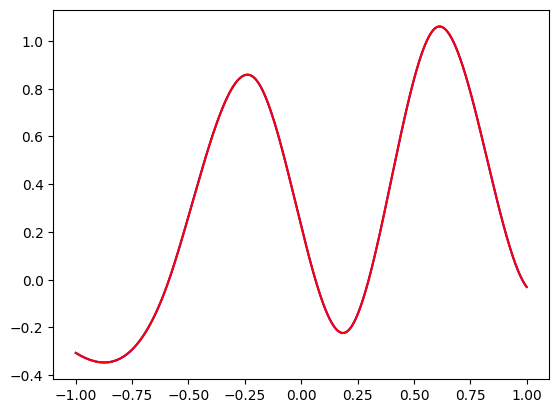

In [58]:
from matplotlib import pyplot as plt
plt.plot(t, normal_res, color='blue')
plt.plot(t, cache_res, color='red')